In [2]:
import os
import numpy as np
import matplotlib.pyplot as plt
plt.rcParams['mathtext.fontset'] = 'stix'

# Calculate $\kappa$ sampled from the first training

In the first training, we let 200 independent LSTMs predict 200 trajectories of 200$ns$. Since we are using LSTM as a generative model, we can also train just one LSTM and use it to generate 200 predictions, starting from either the same initial condition or different initial conditions.

Data location: `./Output/`

In [3]:
output_dir='./Output'
kappa_list=[]

for i in range(200):

    pred_dir=os.path.join(output_dir, '{}/prediction.npy'.format(i))
    prediction=np.load(pred_dir)

    N0=len(np.where(prediction<=15)[0])
    N1=len(np.where(prediction>=16)[0])
    kappa=N0/N1
    kappa_list.append(kappa)
    
kappa_arr=np.array(kappa_list)

Plot distribution of $\kappa$

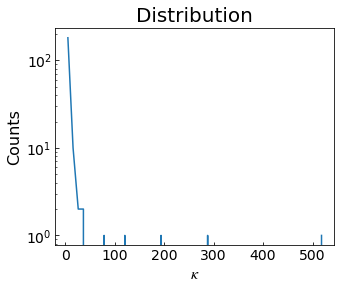

In [4]:
# Plot distribution
hist = np.histogram( kappa_arr, bins=50 )
prob = hist[0].T
mids = 0.5*(hist[1][1:]+hist[1][:-1])

fig, ax = plt.subplots(figsize=(5,4))

ax.set_title('Distribution', size=20)
ax.plot(mids, prob)

ax.tick_params(axis='both', which='both', direction='in', labelsize=14)
ax.set_xlabel('$\kappa$', size=16)
ax.set_ylabel('Counts', size=16)
ax.set_yscale('log')

plt.show()

# Determine $\Delta\lambda$

Following the reference, we want to solve the following equation for $\Delta\lambda$

\begin{align}
    \bar{s}^{(j)}_2&=\sum_{\Gamma}P^{(2)}_{\Gamma}s^{(j)}_{\Gamma} \nonumber \\
    &=\frac{\sum_{k\in\Omega} s^{(j)}_k e^{-\Delta\lambda_j s^{(j)}_k} }{\sum_{k\in\Omega} e^{-\Delta\lambda_j s^{(j)}_k}} \\
    &=f(\Delta\lambda)
    \label{eq:lambda_solver}
\end{align}


To determine the $\Delta\lambda$ value, we can calculate the above equation and plot it versus $\Delta\lambda$, and find $\Delta\lambda=\Delta\lambda_{\ast}$ which gives 
\begin{align}
\bar{s}^{(j)}_2=f(\Delta\lambda_{\ast})=s^{\rm target}
\end{align}


### $s=\kappa$

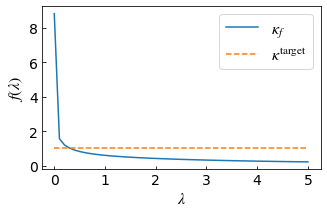

f(0.317) = 1.000


In [5]:
def f(lm):
    return np.sum(kappa_arr*np.exp(-lm*kappa_arr))/np.sum(np.exp(-lm*kappa_arr))

lm_arr = np.linspace(0,5)
f_arr = [f(lm_i) for lm_i in lm_arr]


fig, ax=plt.subplots(figsize=(5,3))

ax.plot(lm_arr, f_arr, label='$\kappa_f$')
ax.plot(lm_arr, [1]*len(lm_arr), '--', label='$\kappa^{\mathrm{target}}$')

ax.tick_params(axis='both', which='both', direction='in', labelsize=14)
ax.set_xlabel('$\lambda$', size=16)
ax.set_ylabel('$f(\lambda)$', size=16)

ax.legend(fontsize=16)

plt.show()

lm=0.317
print( 'f({:.3f}) = {:.3f}'.format(lm, f(lm)) )

Let's see if select 10 predictions to build the subset is enough.

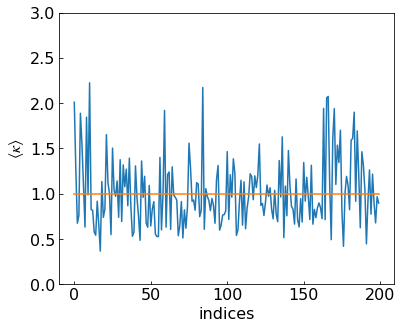

In [6]:
lm_ast=0.317 # Delta_lambda we used for bias sampling
p=np.exp(-lm_ast*(kappa_arr))
p/=np.sum(p)

subset_mean_arr = []
for i in range(200):
    idx = np.random.choice(len(kappa_arr), 10, p=p)
    selected = kappa_arr[idx]
    
    mean=np.mean(selected)
    
    subset_mean_arr.append(mean)
    
fig, ax = plt.subplots(figsize=(6,5), nrows=1, ncols=1)

ax.plot(subset_mean_arr)
ax.plot(np.arange(len(subset_mean_arr)), [1.0]*len(subset_mean_arr), label="constraint $\kappa$")

ax.tick_params(axis='both', which='both', direction='in', labelsize=16)
ax.set_xlabel('indices', size=16)
ax.set_ylabel('$\langle\kappa\\rangle$', size=16)
ax.set_ylim(0.0,3.0)


plt.show()

So we will constrain our $\kappa$ to 1 with standard error 0.081. Even though we believe from the above test the subset size=10 is sufficient, there is still some variance in mean constraint. Therefore, we will also constrain the standard deviation of $\kappa$ in the subset.

In [13]:
lm_ast=0.317
p=np.exp(-lm_ast*(kappa_arr))
p/=np.sum(p)

mean=np.inf
stdv=np.inf
while abs(mean-1)>0.01 or abs(stdv-0.09)>0.01:
    idx = np.random.choice(len(kappa_arr), 10, p=p)
    selected = kappa_arr[idx]
    
    mean=np.mean(selected)
    stdv=np.std(selected)/np.sqrt(len(selected))
    
print( 'mean of selected sample = {:.3f}'.format(np.mean(selected)) )
print( 'Standard error stderr[selected sample] = {:.3f}'.format(np.std(selected)/np.sqrt(len(selected))) )

mean of selected sample = 1.010
Standard error stderr[selected sample] = 0.085


Concatenate the subset to a single trajectory, this concatenated trajectory is then used later to re-train a new LSTM.

# Concatenate subset as a new training set

In [14]:
conc=[]
output_dir='./Output'

for i in idx:
    pred_dir=os.path.join(output_dir, '{}/prediction.npy'.format(i))
    prediction=np.load(pred_dir)
    N0=len(np.where(prediction<=15)[0])
    N1=len(np.where(prediction>=16)[0])
    kappa=N0/N1
    print(kappa)
    
    conc.extend(prediction)
    
conc = np.array(conc)

0.8015989190406486
0.7965416573096789
1.7318112591601047
0.8249673787081055
0.8978032926887128
1.0385489608496672
0.9956395276321238
0.8256337231061333
0.9929648341355016
1.1913725662068437


In [15]:
N0=len(np.where(conc<=15)[0])
N1=len(np.where(conc>=16)[0])
kappa_conc = N0/N1
print('kappa_conc:{:.3f}'.format(kappa_conc))

kappa_conc:0.980
